In [27]:

import pandas as pd
import tiktoken

from openai.embeddings_utils import get_embedding

# Load in the data 


In [28]:
df = pd.read_csv('/Users/ingrid/Downloads/Reviews.csv')

# select the columns
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]

# get a sample of the data - random 1000 rows
# df = df.sample(1000, random_state=42)

# Clean the Data 

In [29]:
print(f"shape of the df is {df.shape}")
df = df.dropna()

print(f"shape of the df after dropping NAs is {df.shape}")

shape of the df is (568454, 6)
shape of the df after dropping NAs is (568427, 6)


In [30]:
# Combine the summary and text columns in a new column called combined

df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)

In [31]:
# subsample to 1k most recent reviews and remove samples that are too long
top_n = 1000
df = df.sort_values("Time").tail(top_n * 2)  # first cut to first 2k entries, assuming less than half will be filtered out
df.drop("Time", axis=1, inplace=True)


In [32]:
df.head()

,ProductId,UserId,Score,Summary,Text,combined
467784,B000V1O28Y,A1CHFK7Z8ZJBQ7,4,Better than I thought they would be!,These were actually quite tasty despite the ex...,Title: Better than I thought they would be!; C...
102286,B001QEB3E6,AY2O7I9BNG2UI,4,"Dog loves them, but I hate the smell","I have a 70 pound lab mix, and he goes nuts fo...","Title: Dog loves them, but I hate the smell; C..."
228586,B00295IGHS,A37VSXI1MDHBWJ,2,Too runny for my taste,"I bought this to use to give my dogs pills, so...",Title: Too runny for my taste; Content: I boug...
149371,B006BXUKAA,A2Y2RTN8AZ9C7F,2,Smells like the beans are flavored with alcohol,"When I opened the back, the overwhelming alcoh...",Title: Smells like the beans are flavored with...
175998,B007TGO1U8,A2FHXIKEYLW2C0,1,Aftertaste,"I am disappointed in this product. First, ther...",Title: Aftertaste; Content: I am disappointed ...


In [33]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 467784 to 542496
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ProductId  2000 non-null   object
 1   UserId     2000 non-null   object
 2   Score      2000 non-null   int64 
 3   Summary    2000 non-null   object
 4   Text       2000 non-null   object
 5   combined   2000 non-null   object
dtypes: int64(1), object(5)
memory usage: 109.4+ KB


# Prepare for Embeddings

In [34]:
# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191|

In [35]:

encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens].tail(top_n)
len(df)

1000

In [36]:
df.head()

,ProductId,UserId,Score,Summary,Text,combined,n_tokens
284931,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52
220696,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...,35
107907,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...,"Title: It isn't blanc mange, but isn't bad . ....",267
107799,B004AHGBX4,A2UY46X0OSNVUQ,3,These also have SALT and it's not sea salt.,I like the fact that you can see what you're g...,Title: These also have SALT and it's not sea s...,239
205312,B001BORBHO,A1AFOYZ9HSM2CZ,5,Happy with the product,My dog was suffering with itchy skin. He had ...,Title: Happy with the product; Content: My dog...,86


**Save the embeddings**

In [ ]:
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))


In [38]:
df.to_csv("fine_food_reviews_with_embeddings_1k.csv")

## Section 2: K-means clustering in Python using OpenAI 

In [41]:
from ast import literal_eval

import numpy as np

In [42]:
# load data
datafile_path = "fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(df.embedding.values)
matrix.shape

(1000, 1536)

In [43]:
from sklearn.cluster import KMeans

# set the number of clusters
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").Score.mean().sort_values()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster
2    4.104839
0    4.191176
1    4.215613
3    4.308357
Name: Score, dtype: float64

**Plot the cluster**

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

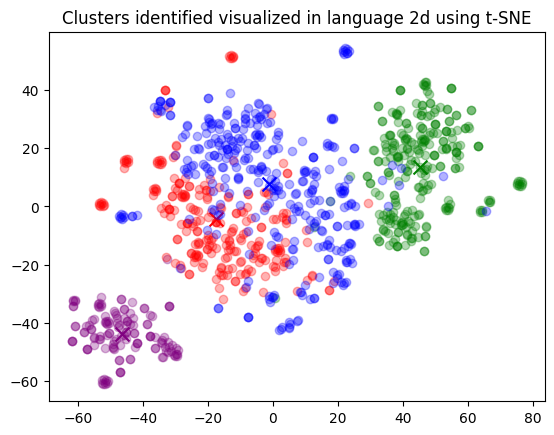

In [44]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

**Use OpenAI to Name the Clusters**

In [45]:
import openai

# Reading a review which belong to each group.
rev_per_cluster = 5

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.Score.values[j], end=", ")
        print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.Text.str[:70].values[j])

    print("-" * 100)

Cluster 0 Theme:  All of the reviews are positive and discuss the benefits of the product.
5, Dogs love it.:   This is the "all gone" treat after dinner.  It's the only treat that t
2, Triggered strange vomit response to my dog:   I can't deny that these smell amazing- all the fruitables that I order
4, Very convenient:   Before I order anything online, I try to research as much as possible.
5, These are excellent and excellent $$$$ here at Amazon:   This Old Dawg [Chihuahua] has been eating these for years [Bacon Strip
4, Great food!:   I wanted a food for a a dog with skin problems. His skin greatly impro
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  All of the reviews are positive and provide feedback on the quality of the product.
5, Emerils Big Easy:   Best coffee available, I drink it on the middle setting of the five ou
1, Buyer beware:   Nespresso makes GREAT coffee and GREAT machines. The Nespresso capsul